In [1]:
# STEP 1: Install dependencies
!pip install torch torchvision matplotlib tqdm numpy pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [20]:
import os

def count_jpg_files(directory):
    count = 0
    for filename in os.listdir(directory):
        if filename.lower().endswith('.jpg'):
            count += 1
    return count

# Example usage
directory_path = '/content/sample_data/CHAOS/Train/'  # Replace with your directory path
jpg_count = count_jpg_files(directory_path)
print(f"Number of .jpg files: {jpg_count}")


Number of .jpg files: 0


In [28]:
#Import the libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [29]:
# ========== Dataset ==========
class CTImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_path = "/content/sample_data/CHAOS/Train/CT"
dataset = CTImageDataset(image_dir=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [30]:
# ========== Generator ==========
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, base_channels=64):
        super().__init__()
        self.enc1 = UNetBlock(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = UNetBlock(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = UNetBlock(base_channels * 2, base_channels * 4)

        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec2 = UNetBlock(base_channels * 4, base_channels * 2)
        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec1 = UNetBlock(base_channels * 2, base_channels)

        self.final = nn.Sequential(
            nn.Conv2d(base_channels, in_channels, 1),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)


In [31]:
# ========== Discriminator ==========
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [37]:
# ========== Diffusion Scheduler ==========
class DiffusionScheduler:
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        self.betas = self._cosine_beta_schedule(timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)
        self.sqrt_alphas_cumprod = torch.tensor(np.sqrt(self.alphas_cumprod), dtype=torch.float32)
        self.sqrt_one_minus_alphas_cumprod = torch.tensor(np.sqrt(1 - self.alphas_cumprod), dtype=torch.float32)

    def _cosine_beta_schedule(self, timesteps, s=0.008):
        steps = timesteps + 1
        x = np.linspace(0, timesteps, steps)
        alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return np.clip(betas, 0.0001, 0.9999)

    def add_noise(self, x, t):
        noise = torch.randn_like(x)
        t = t.long()

        # Move scheduler tensors to the same device as input `x`
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(x.device)
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(x.device)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]

        return sqrt_alphas_cumprod_t * x + sqrt_one_minus_alphas_cumprod_t * noise, noise

In [38]:
# ========== Training ==========
def train(generator, discriminator, dataloader, scheduler, device, num_epochs=30):
    gen_opt = optim.Adam(generator.parameters(), lr=1e-4)
    disc_opt = optim.Adam(discriminator.parameters(), lr=1e-4)

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for real in tqdm(dataloader):
            real = real.to(device)
            bs = real.size(0)

            t = torch.randint(0, scheduler.timesteps, (bs,), device=device)
            noised, noise = scheduler.add_noise(real, t)

            pred_noise = generator(noised)
            reconstructed = noised - pred_noise

            # === Discriminator ===
            disc_real = discriminator(real)
            disc_fake = discriminator(reconstructed.detach())
            real_labels = torch.ones_like(disc_real)
            fake_labels = torch.zeros_like(disc_fake)

            loss_disc = bce_loss(disc_real, real_labels) + bce_loss(disc_fake, fake_labels)

            disc_opt.zero_grad()
            loss_disc.backward()
            disc_opt.step()

            # === Generator ===
            disc_fake = discriminator(reconstructed)
            loss_gen = mse_loss(pred_noise, noise) + 0.1 * bce_loss(disc_fake, real_labels)

            gen_opt.zero_grad()
            loss_gen.backward()
            gen_opt.step()

        print(f"Loss Gen: {loss_gen.item():.4f}, Loss Disc: {loss_disc.item():.4f}")

    # Save model after training
    torch.save(generator.state_dict(), "diffusion_gan_generator.pth")
    print("Model saved as 'diffusion_gan_generator.pth'.")

In [39]:
# ========== Visualization ==========
def visualize(generator, scheduler, dataloader, device):
    generator.eval()
    with torch.no_grad():
        real = next(iter(dataloader)).to(device)
        bs = real.size(0)
        t = torch.randint(0, scheduler.timesteps, (bs,), device=device)
        noised, _ = scheduler.add_noise(real, t)
        pred_noise = generator(noised)
        reconstructed = noised - pred_noise

        for i in range(1):  # show only 1 sample
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(real[i].cpu().squeeze(), cmap='gray')
            axs[0].set_title("Original")
            axs[1].imshow(noised[i].cpu().squeeze(), cmap='gray')
            axs[1].set_title("Noised")
            axs[2].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
            axs[2].set_title("Generated")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()
    generator.train()


Epoch 1/50


100%|██████████| 31/31 [00:06<00:00,  5.02it/s]


Loss Gen: 0.8319, Loss Disc: 1.1520
Epoch 2/50


100%|██████████| 31/31 [00:04<00:00,  6.70it/s]


Loss Gen: 0.4416, Loss Disc: 1.2099
Epoch 3/50


100%|██████████| 31/31 [00:04<00:00,  6.60it/s]


Loss Gen: 0.3247, Loss Disc: 1.0436
Epoch 4/50


100%|██████████| 31/31 [00:04<00:00,  6.53it/s]


Loss Gen: 0.4707, Loss Disc: 0.9475
Epoch 5/50


100%|██████████| 31/31 [00:04<00:00,  6.52it/s]


Loss Gen: 0.3059, Loss Disc: 0.9668
Epoch 6/50


100%|██████████| 31/31 [00:04<00:00,  6.61it/s]


Loss Gen: 0.3283, Loss Disc: 0.8734
Epoch 7/50


100%|██████████| 31/31 [00:04<00:00,  6.67it/s]


Loss Gen: 0.3134, Loss Disc: 0.8217
Epoch 8/50


100%|██████████| 31/31 [00:04<00:00,  6.70it/s]


Loss Gen: 0.3047, Loss Disc: 0.7548
Epoch 9/50


100%|██████████| 31/31 [00:04<00:00,  6.76it/s]


Loss Gen: 0.3284, Loss Disc: 0.6692
Epoch 10/50


100%|██████████| 31/31 [00:04<00:00,  6.80it/s]


Loss Gen: 0.3112, Loss Disc: 0.6603
Epoch 11/50


100%|██████████| 31/31 [00:04<00:00,  6.85it/s]


Loss Gen: 0.3479, Loss Disc: 0.5518
Epoch 12/50


100%|██████████| 31/31 [00:04<00:00,  6.87it/s]


Loss Gen: 0.4269, Loss Disc: 0.5135
Epoch 13/50


100%|██████████| 31/31 [00:04<00:00,  6.89it/s]


Loss Gen: 0.3377, Loss Disc: 0.5266
Epoch 14/50


100%|██████████| 31/31 [00:04<00:00,  6.90it/s]


Loss Gen: 0.3567, Loss Disc: 0.5114
Epoch 15/50


100%|██████████| 31/31 [00:04<00:00,  6.88it/s]


Loss Gen: 0.3153, Loss Disc: 0.5205
Epoch 16/50


100%|██████████| 31/31 [00:04<00:00,  6.83it/s]


Loss Gen: 0.3628, Loss Disc: 0.4092
Epoch 17/50


100%|██████████| 31/31 [00:04<00:00,  6.86it/s]


Loss Gen: 0.3347, Loss Disc: 0.4214
Epoch 18/50


100%|██████████| 31/31 [00:04<00:00,  6.83it/s]


Loss Gen: 0.3160, Loss Disc: 0.5217
Epoch 19/50


100%|██████████| 31/31 [00:04<00:00,  6.84it/s]


Loss Gen: 0.3618, Loss Disc: 0.3611
Epoch 20/50


100%|██████████| 31/31 [00:04<00:00,  6.79it/s]


Loss Gen: 0.4861, Loss Disc: 0.2907
Epoch 21/50


100%|██████████| 31/31 [00:04<00:00,  6.78it/s]


Loss Gen: 0.3735, Loss Disc: 0.3202
Epoch 22/50


100%|██████████| 31/31 [00:04<00:00,  6.77it/s]


Loss Gen: 0.4871, Loss Disc: 0.2491
Epoch 23/50


100%|██████████| 31/31 [00:04<00:00,  6.74it/s]


Loss Gen: 0.4135, Loss Disc: 0.2404
Epoch 24/50


100%|██████████| 31/31 [00:04<00:00,  6.75it/s]


Loss Gen: 0.5227, Loss Disc: 0.2086
Epoch 25/50


100%|██████████| 31/31 [00:04<00:00,  6.75it/s]


Loss Gen: 0.5567, Loss Disc: 0.2431
Epoch 26/50


100%|██████████| 31/31 [00:04<00:00,  6.75it/s]


Loss Gen: 0.4390, Loss Disc: 0.2121
Epoch 27/50


100%|██████████| 31/31 [00:04<00:00,  6.76it/s]


Loss Gen: 0.4250, Loss Disc: 0.2425
Epoch 28/50


100%|██████████| 31/31 [00:04<00:00,  6.75it/s]


Loss Gen: 0.5523, Loss Disc: 0.1775
Epoch 29/50


100%|██████████| 31/31 [00:04<00:00,  6.75it/s]


Loss Gen: 0.4699, Loss Disc: 0.1538
Epoch 30/50


100%|██████████| 31/31 [00:04<00:00,  6.79it/s]


Loss Gen: 0.4493, Loss Disc: 0.1885
Epoch 31/50


100%|██████████| 31/31 [00:04<00:00,  6.80it/s]


Loss Gen: 0.4379, Loss Disc: 0.1809
Epoch 32/50


100%|██████████| 31/31 [00:04<00:00,  6.82it/s]


Loss Gen: 0.5184, Loss Disc: 0.1543
Epoch 33/50


100%|██████████| 31/31 [00:04<00:00,  6.82it/s]


Loss Gen: 0.4187, Loss Disc: 0.2829
Epoch 34/50


100%|██████████| 31/31 [00:04<00:00,  6.80it/s]


Loss Gen: 0.4425, Loss Disc: 0.1953
Epoch 35/50


100%|██████████| 31/31 [00:04<00:00,  6.83it/s]


Loss Gen: 0.4815, Loss Disc: 0.1622
Epoch 36/50


100%|██████████| 31/31 [00:04<00:00,  6.82it/s]


Loss Gen: 0.5206, Loss Disc: 0.1153
Epoch 37/50


100%|██████████| 31/31 [00:04<00:00,  6.82it/s]


Loss Gen: 0.4648, Loss Disc: 0.1579
Epoch 38/50


100%|██████████| 31/31 [00:04<00:00,  6.82it/s]


Loss Gen: 0.4869, Loss Disc: 0.1216
Epoch 39/50


100%|██████████| 31/31 [00:04<00:00,  6.81it/s]


Loss Gen: 0.6046, Loss Disc: 0.1172
Epoch 40/50


100%|██████████| 31/31 [00:04<00:00,  6.81it/s]


Loss Gen: 0.5208, Loss Disc: 0.1156
Epoch 41/50


100%|██████████| 31/31 [00:04<00:00,  6.79it/s]


Loss Gen: 0.4883, Loss Disc: 0.1085
Epoch 42/50


100%|██████████| 31/31 [00:04<00:00,  6.79it/s]


Loss Gen: 0.4634, Loss Disc: 0.1273
Epoch 43/50


100%|██████████| 31/31 [00:04<00:00,  6.81it/s]


Loss Gen: 0.5609, Loss Disc: 0.1095
Epoch 44/50


100%|██████████| 31/31 [00:04<00:00,  6.80it/s]


Loss Gen: 0.5339, Loss Disc: 0.0943
Epoch 45/50


100%|██████████| 31/31 [00:04<00:00,  6.80it/s]


Loss Gen: 0.5799, Loss Disc: 0.0888
Epoch 46/50


100%|██████████| 31/31 [00:04<00:00,  6.78it/s]


Loss Gen: 0.5884, Loss Disc: 0.0764
Epoch 47/50


100%|██████████| 31/31 [00:04<00:00,  6.76it/s]


Loss Gen: 0.5172, Loss Disc: 0.0952
Epoch 48/50


100%|██████████| 31/31 [00:04<00:00,  6.76it/s]


Loss Gen: 0.5253, Loss Disc: 0.0807
Epoch 49/50


100%|██████████| 31/31 [00:04<00:00,  6.80it/s]


Loss Gen: 0.5407, Loss Disc: 0.0756
Epoch 50/50


100%|██████████| 31/31 [00:04<00:00,  6.80it/s]


Loss Gen: 0.5395, Loss Disc: 0.0840
Model saved as 'diffusion_gan_generator.pth'.


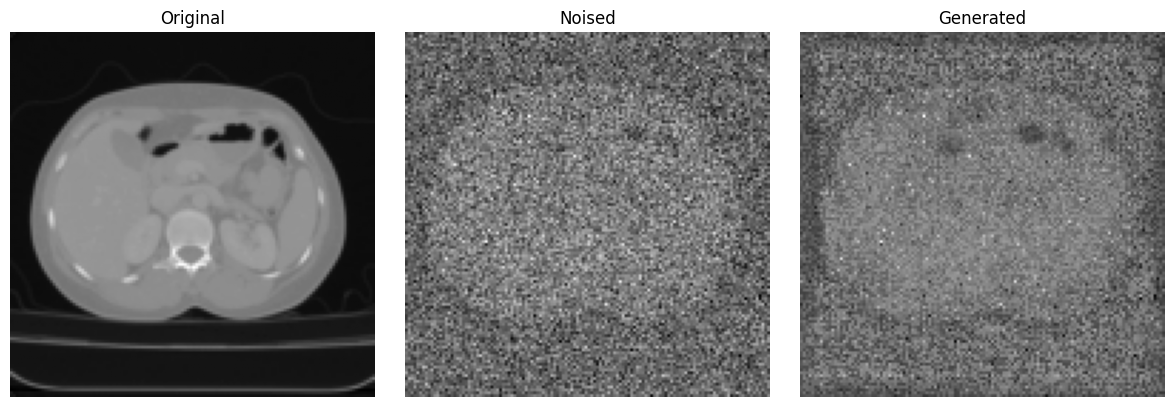

In [40]:
# ========== Run Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)
scheduler = DiffusionScheduler(timesteps=1000)

train(generator, discriminator, dataloader, scheduler, device, num_epochs=50)
visualize(generator, scheduler, dataloader, device)